# Telecom project

## Project description

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

**Interconnect's services**  

Interconnect mainly provides two types of services:
1. Landline communication. The telephone can be connected to several lines simultaneously.  
1. Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.  

Some other services the company provides include:
- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)  

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:
- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

## My Plan to a
* Perform EDA
* Extract features
* Train test split
* Also split for validation/test sets
* Fill in missing values
* Transform existing features if necessary
* Address the imbalance by upscaling/downscaling/weight assignment
* Scale the data
* build a baseline model for sanity check
* Choose the best performing model

## Project initialization

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.utils import resample
from numpy.random import RandomState
import lightgbm as lgb
import warnings
from IPython.display import clear_output


from sklearn.linear_model import LogisticRegression

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import keras
from keras.layers import *
import tensorflow as tf

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

from catboost import CatBoostClassifier, Pool, cv

# from keras.optimizers import RMSprop

from random import seed
warnings.filterwarnings('ignore')

### Load dataset

In [2]:
path_data_folder = 'final_provider/final_provider/'
df_contract = pd.read_csv(path_data_folder + 'contract.csv')
df_internet = pd.read_csv(path_data_folder + 'internet.csv')
df_personal = pd.read_csv(path_data_folder + 'personal.csv')
df_phone = pd.read_csv(path_data_folder + 'phone.csv')

In [3]:
list_all_df = [df_contract,
    df_internet,
    df_personal,
    df_phone]

In [4]:
list_all_df_names = ['df_contract',
    'df_internet',
    'df_personal',
    'df_phone']

Lets take a look at all the tables

In [5]:
for i in range(len(list_all_df)):
    print(f'{list_all_df_names[i]}')
    display(list_all_df[i].sample(3, random_state=23443))
    print()

df_contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3687,6849-OYAMU,2018-03-01,2019-10-01 00:00:00,One year,No,Bank transfer (automatic),100.00,1888.65
2659,3166-PNEOF,2015-01-01,No,Two year,No,Credit card (automatic),86.45,5175.3
712,9661-JALZV,2015-04-01,No,Two year,Yes,Credit card (automatic),24.70,1519



df_internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1138,6718-BDGHG,DSL,No,No,No,Yes,Yes,No
111,7850-VWJUU,Fiber optic,Yes,No,No,No,No,No
3539,4910-AQFFX,Fiber optic,No,No,Yes,No,No,No



df_personal


,customerID,gender,SeniorCitizen,Partner,Dependents
3687,6849-OYAMU,Male,0,Yes,Yes
2659,3166-PNEOF,Female,0,No,No
712,9661-JALZV,Female,0,No,No



df_phone


,customerID,MultipleLines
2263,0397-GZBBC,Yes
1755,2123-VSCOT,Yes
2530,9375-MHRRS,No


Lets alsoo look at the information on the datasets

In [6]:
for i in range(len(list_all_df)):
    print(f'{list_all_df_names[i]} info')
    print(list_all_df[i].info())
    print()

df_contract info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

df_internet info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   o

### Transforming types

We can transform *BeginDate* to datetime64 type.  
We can't do the same however for the *EndDate* feature as it contains *No* values along the dates.  
Other features would be transformed after the EDA so we first examine their raw values.

In [7]:
df_contract['BeginDate'] = df_contract['BeginDate'].astype('datetime64[D]')

Also we see that the column *TotalCharges* has *object* as the *dtype* despite its values being numeric.  
Probably there are some non numeric.  
Let's dive into these values.

In [8]:
df_contract[pd.to_numeric(df_contract['TotalCharges'], errors='coerce').isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


It looks like:  
* All the non numeric values are empty
* All these missing values come from the day the dataset was collected  

The customers who signed on the same day the data was collected are too new.  
Especially considering that in many cases the reporting on new customers and the leaving ones are done separately and new customers are processed fater than the leaving ones for obvious reasons.  
I think it would be wrong to include them into the model.  
So we dismiss every record of customers that joined on 2020-02-01.

In [9]:
df_contract = df_contract.query('BeginDate != "2020-02-01"')

In [10]:
df_contract.loc[pd.to_numeric(df_contract['TotalCharges'], errors='coerce').isna(), 'TotalCharges'] = 0

Now we can change the type of *TotalCharges* to numeric.

In [11]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')

### Checking for NaN values

In [12]:
for i in range(len(list_all_df)):
    print(f'{list_all_df_names[i]} has {list_all_df[i].isna().sum().sum()} NaN values.')

df_contract has 0 NaN values.
df_internet has 0 NaN values.
df_personal has 0 NaN values.
df_phone has 0 NaN values.


It looks like each dataset by it doesn't contain any NaN.  
However they can occur if we join them altogether.

### Checking for duplicates

The only relevant feature here to check for duplicate is *customerID*,  
As all other features can be similar for a group of clients.

In [13]:
for i in range(len(list_all_df)):
    print(f'{list_all_df_names[i]} has {list_all_df[i]["customerID"].duplicated().sum()} duplicate values.')

df_contract has 0 duplicate values.
df_internet has 0 duplicate values.
df_personal has 0 duplicate values.
df_phone has 0 duplicate values.


### Merging tables

In [14]:
df_full = df_contract.merge(
    df_internet, on='customerID', how='left').merge(
    df_personal, on='customerID', how='left').merge(
    df_phone, on='customerID', how='left')
display(df_full.sample(5, random_state=33674))
print(f'\nThe shape of the dataframe after merge is {df_full.shape}.')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
462,0880-TKATG,2019-07-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,101.15,385.90,Fiber optic,No,No,Yes,No,Yes,Yes,Male,0,Yes,Yes,Yes
5576,4667-OHGKG,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,19.30,19.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No
3254,9620-ENEJV,2019-08-01,No,Month-to-month,No,Credit card (automatic),70.55,433.95,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
6693,2737-WFVYW,2019-08-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,45.25,85.50,DSL,No,No,No,No,Yes,Yes,Female,0,No,No,NaN
1448,5899-OUVKV,2017-07-01,No,Month-to-month,Yes,Electronic check,94.50,2979.20,Fiber optic,No,Yes,No,No,Yes,Yes,Male,0,No,No,No



The shape of the dataframe after merge is (7032, 20).


The combined dataframe looks correct.  
As expected it has NaN values, let's check how many nan values do we have.

In [15]:
df_full.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        680
dtype: int64

Let's also see how many of the customers have at least 1 missing feature

In [16]:
n_rows_with_missing_values_in_df_full = df_full.isna().any(axis=1).sum()
print(f'There are {n_rows_with_missing_values_in_df_full} records with at least one NaN')

There are 2200 records with at least one NaN


In [17]:
print('{:.2%} of the records have missing values'.format(
    n_rows_with_missing_values_in_df_full / len(df_full)))

31.29% of the records have missing values


We have 31.35% rows with missing values.  
As we know all of them except for missing values in *MultipleLines* column are missing together.  
So if we decide to dismiss some of the values and keep others it will be only possible to dismiss records with missing values in MultipleLines feature.  
Lets calculate how many records would we lose in that case.

In [18]:
print('{:.2%} of the records have missing value in MultipleLines column'.format(
    df_full['MultipleLines'].isna().sum() / len(df_full)))

9.67% of the records have missing value in MultipleLines column


We have 31.35% rows with missing values.  
If we look only at missing values in MultipleLines feature than we have 9.68% of missing values. We'll deal with them later in preprocessing.

## Train-test split

Performing the split now, so all the EDA would be done only on the train set.  
This way the test set would simulate the "new" data more precisely.

In [19]:
df_train, df_test = train_test_split(df_full, test_size=0.25, random_state=123243)

In [20]:
df_train, df_test = train_test_split(df_full, test_size=0.25, random_state=1543)

In [21]:
# df_train, df_test = train_test_split(df_full, test_size=0.4, random_state=356123)

## EDA

### Histograms of initial data

In [22]:
list_features_distplot = ['BeginDate',
                         'MonthlyCharges',
                         'TotalCharges']

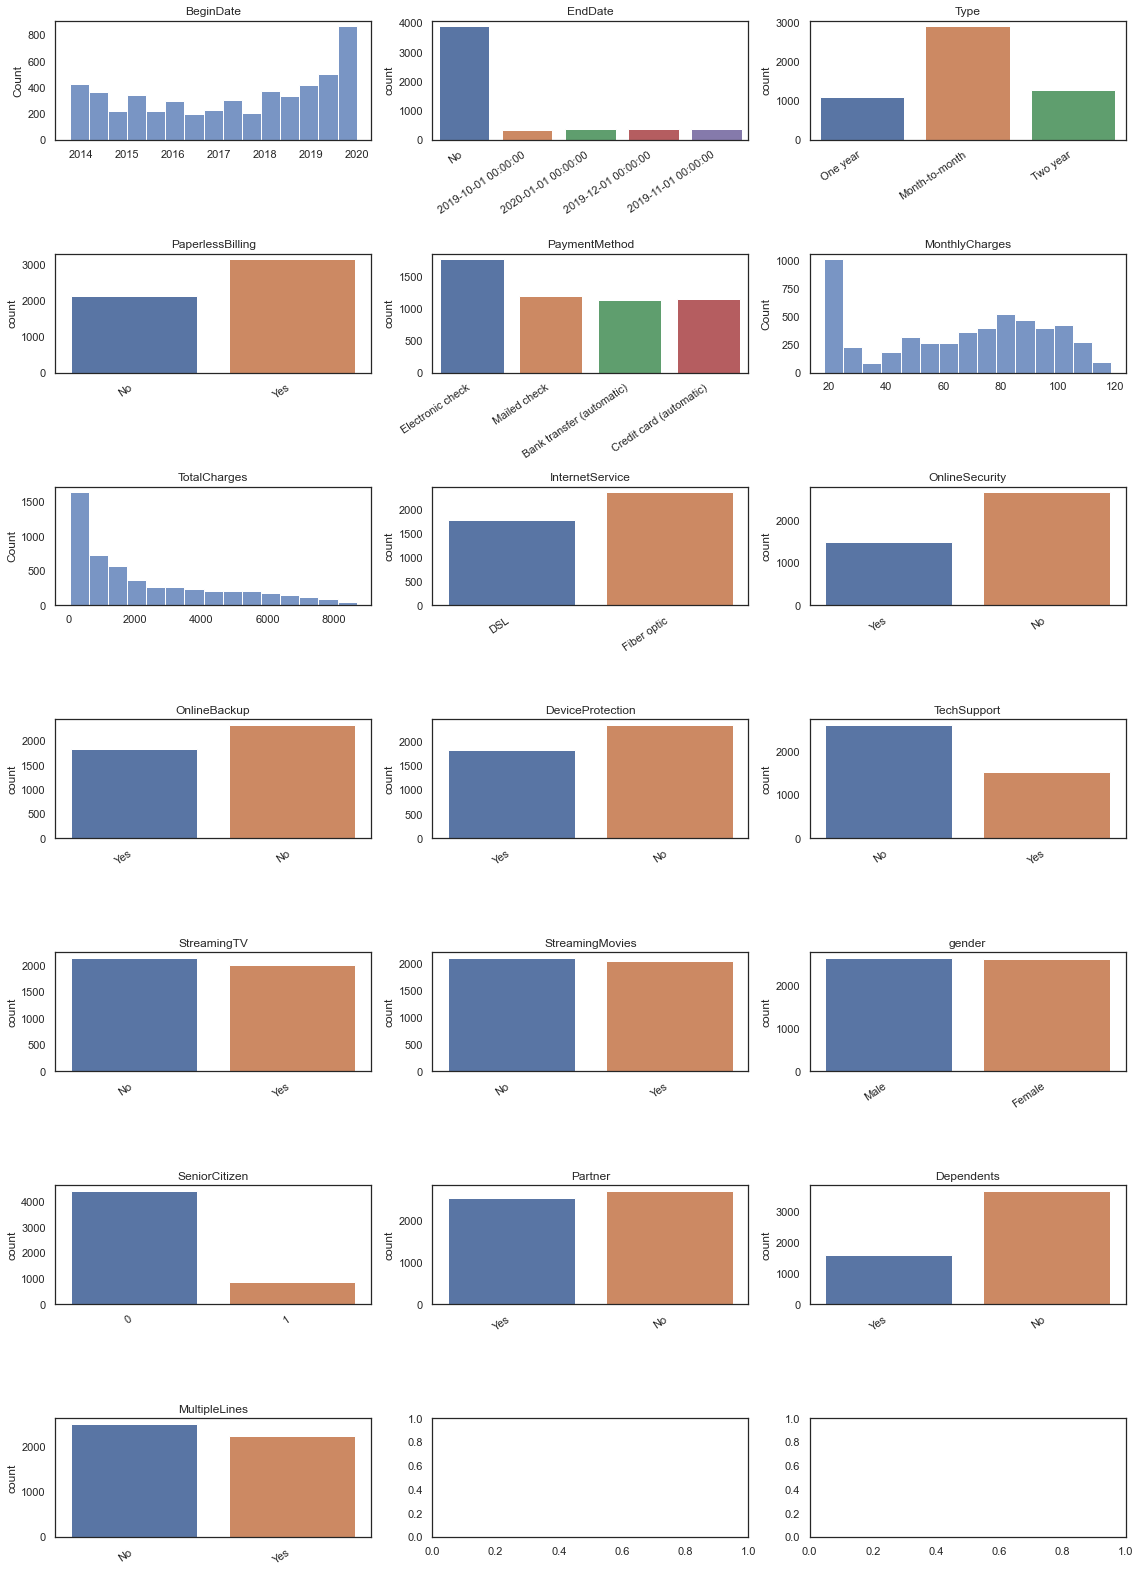

In [23]:
sns.set(rc = {'figure.figsize':(16,22)})
sns.set_theme(style='white')
fig, axes = plt.subplots(nrows=7, ncols=3, sharey=False, sharex=False)

for i in range(19):
    ax = axes[int(i / 3)][i % 3]
    if df_train.columns[i+1] in list_features_distplot:
        sns.histplot(df_train[df_train.columns[i+1]], ax=ax, bins=15)
    else:
        sns.countplot(df_train[df_train.columns[i+1]], ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=34, horizontalalignment='right')
    ax.set(
        title=df_train.columns[i+1])
    ax.set_xlabel('')
    
plt.tight_layout()
plt.show()

**Insights**  

* last 2 years there is a growth in new customers. seems like a good sign for a business.  
* Most of the customers don't have end date. It would be a bad sign if it was otherwise.  
* Since the *EndDate* feature will be also traslated to the target - we may see visually that the dataset is unbalanced.  
* The majority of people prefer month-to-month payment as well as electronic check - a combination of easy to use and no automatic payments, which indicates more wise customers.
* On the other services most of the services are used by half of the customers, except for the online security which is used by a minority, which makes sense, because that is a service that is usually better provided not by ISP.
* Most of the customers are not seniors.
* Also most of the customers don't have dependents.
* Based on the 2 previous points it is legitimate to assume that the majority of the customers are young people below 30 years old.
* More people prefer paperless billing, which is also more appealing to the younger generation.

### Feature extraction

We'll add *isActive* feature which indicated if the customer is still in active contract with the company, or if they already left.  
This column will be our target as well.

In [24]:
df_train['isActive'] = df_train['EndDate'] == 'No'

In [25]:
df_train.sample(5, random_state=32467)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,isActive
6791,5626-MGTUK,2018-06-01,No,Month-to-month,Yes,Bank transfer (automatic),89.10,1879.25,Fiber optic,Yes,...,No,No,Yes,No,Female,0,No,No,Yes,True
6763,0970-QXPXW,2020-01-01,No,Month-to-month,No,Mailed check,19.65,19.65,NaN,NaN,...,NaN,NaN,NaN,NaN,Female,0,No,No,No,True
5680,5399-ZIMKF,2019-09-01,No,Month-to-month,Yes,Electronic check,74.65,383.65,Fiber optic,No,...,No,No,No,No,Male,0,No,No,No,True
6055,7568-PODML,2019-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Mailed check,45.30,45.30,DSL,No,...,No,No,Yes,Yes,Male,0,No,No,NaN,False
4668,3011-WQKSZ,2018-07-01,No,Month-to-month,Yes,Electronic check,20.00,377.55,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,No,Yes,No,True


The target column looks OK.  
Lets also add it to the test set.

In [26]:
df_test['isActive'] = df_test['EndDate'] == 'No'

Another useful feature that we could extract is tenure as we have the data we need in the dataset.

In [27]:
def get_tenure(row):
    if row['EndDate'] == 'No':
        result = (pd.to_datetime("February 1, 2020") - row['BeginDate']).days
    else:
        result = (pd.to_datetime(row['EndDate']) - row['BeginDate']).days
    return result

In [28]:
df_train['tenure'] = df_train.apply(get_tenure, axis=1)
df_test['tenure'] = df_test.apply(get_tenure, axis=1)

As this feature may have a lot of values we dont want to plot it with countplot.  
So let's add it to the list of plotting with a histogram.

In [29]:
list_features_distplot.append('tenure')

### Profiling the former customers

Now lets look at the feature distibutions of customers that left.  
May be it would look differently, so we'd better understand the data.

In [30]:
df_temp = df_train.drop('EndDate',axis=1).query('isActive == False')

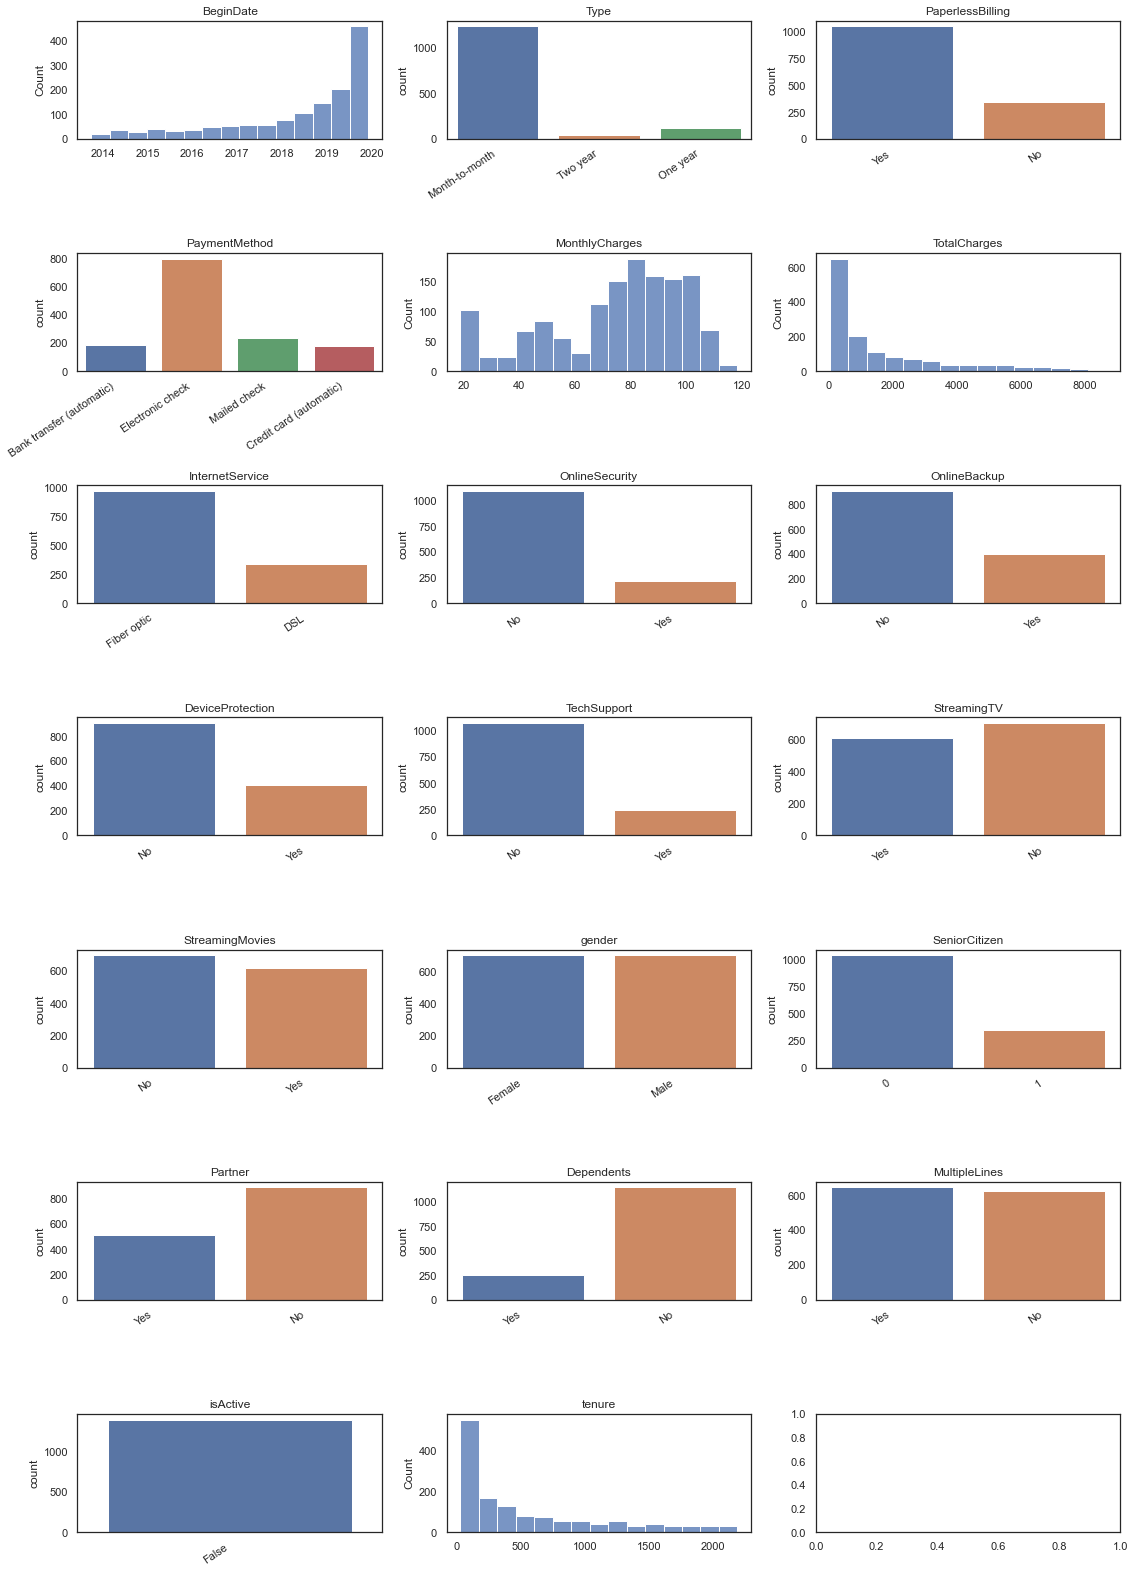

In [31]:
sns.set(rc = {'figure.figsize':(16,22)})
sns.set_theme(style='white')
fig, axes = plt.subplots(nrows=7, ncols=3, sharey=False, sharex=False)

for i in range(len(df_temp.columns) - 1):
    ax = axes[int(i / 3)][i % 3]
    if df_temp.columns[i+1] in list_features_distplot:
        sns.histplot(df_temp[df_temp.columns[i+1]], ax=ax, bins=15)
    else:
        sns.countplot(df_temp[df_temp.columns[i+1]], ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=34, horizontalalignment='right')
    ax.set(
        title=df_temp.columns[i+1])
    ax.set_xlabel('')
    
plt.tight_layout()
plt.show()

Now some of the ditributions look different for sure.  
Let's plot a more accurate grapgh that shows all the information and divides each feature into customers that left and customers that are still with us.  
Then we can jump to our conclusions.

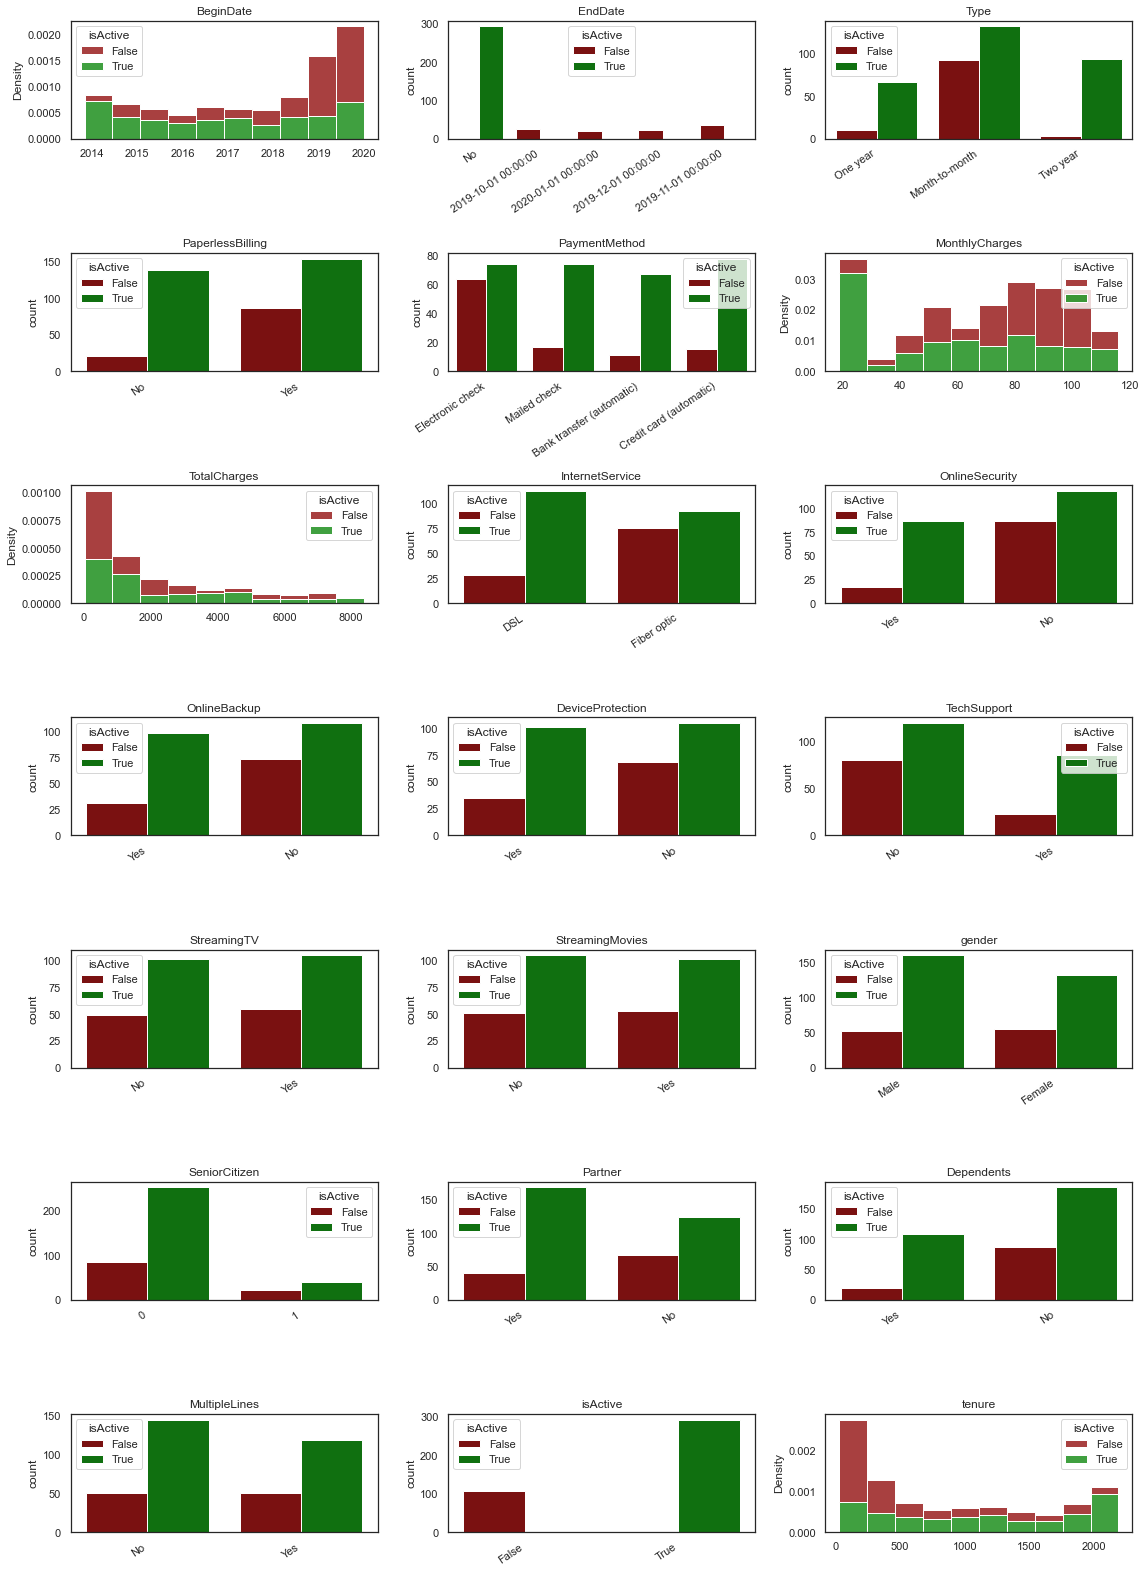

In [32]:
sns.set(rc = {'figure.figsize':(16,22)})
sns.set_theme(style='white')
fig, axes = plt.subplots(nrows=7, ncols=3, sharey=False, sharex=False)

for i in range(len(df_train.columns) - 1):
    ax = axes[int(i / 3)][i % 3]
    if df_train.columns[i+1] in list_features_distplot:
        sns.histplot(df_train.iloc[:400], ax=ax,
            # bins=10,
            x=df_train.columns[i+1],
            hue='isActive',
            stat="density",
            multiple="stack",
            common_norm=False,
            palette=['darkred', 'green']
            )
    else:
        sns.countplot(data=df_train.iloc[:400],
            ax=ax,
            x=df_train.iloc[:400].columns[i+1],
            hue='isActive',
            palette=['darkred', 'green']
            # multiple="stack"
            )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=34, horizontalalignment='right')
    ax.set(
        title=df_train.columns[i+1])
    ax.set_xlabel('')
    
plt.tight_layout()
plt.show()

**Insights**  

* Since 2018 most of the customers that joined the services already left. the trend that continues and goes even higher - not a good sign for the business at all.
* Absolute majority of the customers that left pay month-to-month.
* Most of the former customers preferred paperless billing.
* Almost half of the customers who were billed by electronic check left.
* Looking at the monthy charges distribution most of the former customers paid number of additional services, but not all of them altogether.
* Total Charges distribution shows again that most of the customers who left were relatively new ones.
* Most of the customers who left had Fiber Optic service, which also shows that most of them were more tech advanced customers.  
* Also once again there was a higher percentage of left customers who are not seniors, have no dependents, didn't have tech support included and didn't have online security included - which indicates it is the more younger generation who terminates the contacts with the company.
* Most of the customers who leave don't stay as customers for long time.

### Checking the dataset balance

In [33]:
print('{:.2%} of the targets are positive'.format(df_train['isActive'].mean()))

73.53% of the targets are positive


The data is unbalanced.  
We'll need to adress it later in the preprocessing.

### Correlations between features and target

In [34]:
df_train.corr(method='pearson', min_periods=1)

,MonthlyCharges,TotalCharges,SeniorCitizen,isActive,tenure
MonthlyCharges,1.000000,0.648373,0.215613,-0.191239,0.240548
TotalCharges,0.648373,1.000000,0.102204,0.193983,0.825136
SeniorCitizen,0.215613,0.102204,1.000000,-0.142770,0.016716
isActive,-0.191239,0.193983,-0.142770,1.000000,0.349554
tenure,0.240548,0.825136,0.016716,0.349554,1.000000


Most of the features are categorical.  
Lets encode them into numerical.  
For calculating correlations the simplest ordinal encoder that encodes all the features is sufficient.  
As most of the categorical features are binary anyway.

In [35]:
encoder_for_correlation_purposes = OrdinalEncoder()

In [36]:
df_encoded = df_train.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [37]:
df_encoded = encoder_for_correlation_purposes.fit_transform(df_encoded)

In [38]:
df_encoded = pd.DataFrame(df_encoded, columns = df_train.drop(['customerID', 'BeginDate', 'EndDate'], axis=1).columns)

In [39]:
df_encoded = df_encoded.dropna()

In [40]:
df_encoded.corr()['isActive'].abs().sort_values(ascending=False)[1:]

tenure              0.392269
Type                0.375925
TotalCharges        0.356892
OnlineSecurity      0.271548
TechSupport         0.259097
InternetService     0.246978
OnlineBackup        0.192185
DeviceProtection    0.174233
Partner             0.165333
PaymentMethod       0.154404
Dependents          0.139611
PaperlessBilling    0.134534
SeniorCitizen       0.103654
StreamingMovies     0.035552
StreamingTV         0.027231
MonthlyCharges      0.020653
MultipleLines       0.016488
gender              0.003306
Name: isActive, dtype: float64

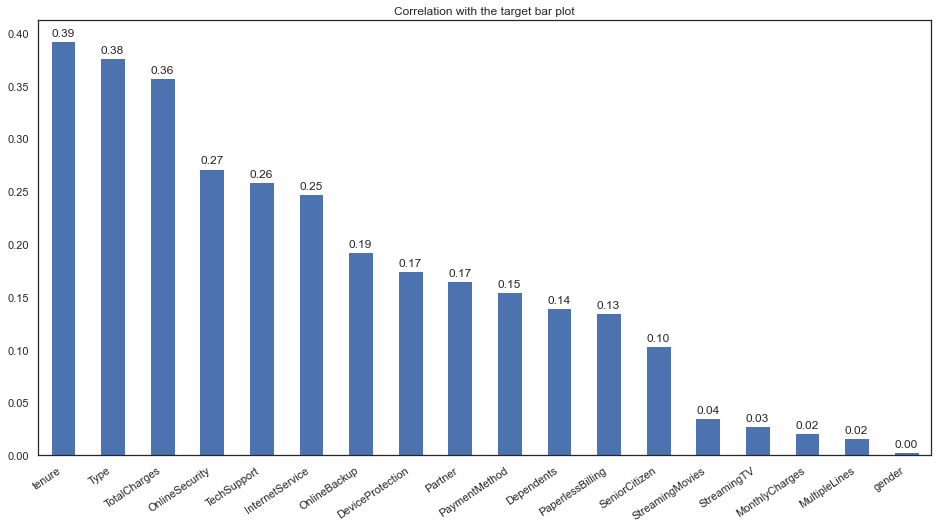

In [41]:
sns.set(rc = {'figure.figsize':(16,8)})
sns.set_theme(style='white')
ax = df_encoded.corr()['isActive'].abs().sort_values(ascending=False)[1:].plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=34, horizontalalignment='right')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
ax.set(title="Correlation with the target bar plot")
plt.show()

In [42]:
df_encoded.corr()['isActive'].abs().sort_values(ascending=False)[:-6].index

Index(['isActive', 'tenure', 'Type', 'TotalCharges', 'OnlineSecurity',
       'TechSupport', 'InternetService', 'OnlineBackup', 'DeviceProtection',
       'Partner', 'PaymentMethod', 'Dependents', 'PaperlessBilling'],
      dtype='object')

In [43]:
# df_encoded = df_encoded[df_encoded.corr()['isActive'].abs().sort_values(ascending=False)[:-6].index]

### Feature importance

Understanding feature importance can also help us choose the right approach to deal with missing values.  
We can train a decision tree on the whole train set to understand what features are most imprtant.  
Let's extract features and targets from the already encoded dataset and train the tree.

In [44]:
from sklearn.metrics import accuracy_score

In [45]:
accuracy_score

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>

In [46]:
X_decision_tree = df_encoded.drop('isActive', axis=1)
y_decision_tree = df_encoded['isActive']

In [47]:
model_decision_tree = DecisionTreeClassifier()

In [48]:
model_decision_tree.fit(X_decision_tree, y_decision_tree)

DecisionTreeClassifier()

First lets see the model performance

In [49]:
model_decision_tree.score(X_decision_tree, y_decision_tree)

0.9997252747252747

Our model is fit very well for the train set and has 99.97% accuracy.  
Good enough for checking feature importance.

In [50]:
df_feature_importance = pd.DataFrame(zip(df_encoded.drop(['isActive'], axis=1).columns,
    model_decision_tree.feature_importances_), columns=['feature', 'importance']).set_index(
    'feature').sort_values(by='importance', ascending=False)
display(df_feature_importance)

,importance
feature,
tenure,0.226797
TotalCharges,0.200148
MonthlyCharges,0.162154
Type,0.148659
PaymentMethod,0.035202
InternetService,0.035121
gender,0.027633
Dependents,0.019908
SeniorCitizen,0.018158


A plot would show the data better

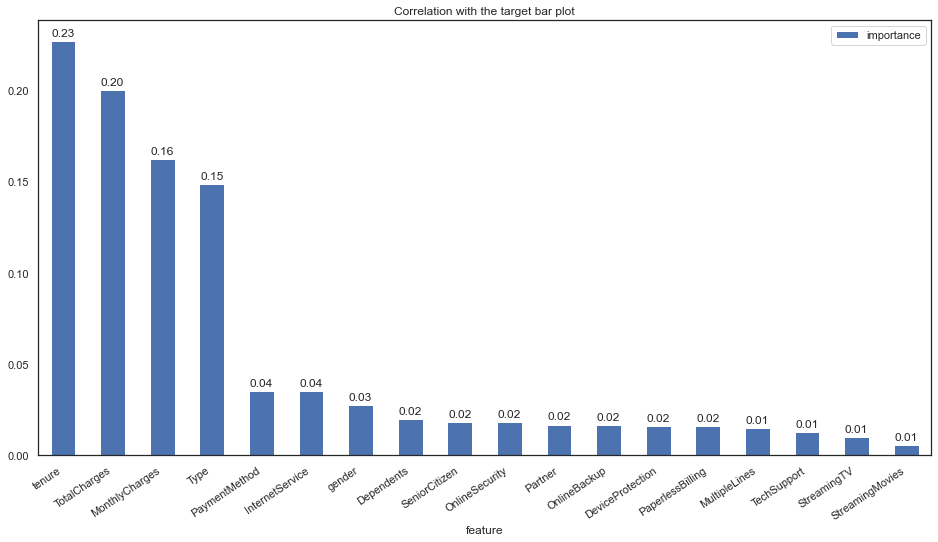

In [51]:
sns.set(rc = {'figure.figsize':(16,8)})
sns.set_theme(style='white')
ax = df_feature_importance.plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=34, horizontalalignment='right')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
ax.set(title="Correlation with the target bar plot")
plt.show()

**Insights**

Most significant features are those in the *contract* dataset which has all of the customers.  
What that essentially mean is if we dismiss all the records with missing "less significant" values we'd lose a lot of important data.  
So the best approach would be to fill all the data.

## Data preprocessing

### Filling in missing values

I see 2 approaches to filling in the missing values:
* Fill everything with 0: This could be a legitimate way as one of the explanations 
* Fill in the missing values with a KNN imputer. So each record would be as close to the similar records  

The most logical explanation for the absense of data in the phone and internet tables is not all customers use both services,  
which means it is safe to assume that all the missing rows in these tables should be 0.  
In addition it also seems wrong to fill in wrong values instead of missing values when most probably the values are missing because the customer doesn't use the mentioned services.  

However I woulnd't choose to fill everything with "No" values as this value suggest that the customer use other related services, i.e. the customer can use StreamingTV but not Online backup. I wouldn't treat the customer the same way as someone with no internet services at all.  
And also "No" in the *phone* dataset means customer has a single line. it would be a different value for someone who doesn't use a phone service at all.  

So I'll fill missing values with *Absent* value, which would indicate that the customer doesn't use any service of the kind.

In [52]:
# df_train = df_train.fillna('aNo internet')
# df_test = df_test.fillna('aNo internet')

In [53]:
df_train = df_train.fillna('absent')
df_test = df_test.fillna('absent')

### Target leakage avoidance and removing excess features

In [54]:
df_train = df_train.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [55]:
df_test = df_test.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

### Target extraction

In [56]:
X_train = df_train.drop('isActive', axis=1)
y_train = df_train['isActive']

In [57]:
X_test = df_test.drop('isActive', axis=1)
y_test = df_test['isActive']

### Data type transformation

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 5641 to 6069
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5274 non-null   object 
 1   PaperlessBilling  5274 non-null   object 
 2   PaymentMethod     5274 non-null   object 
 3   MonthlyCharges    5274 non-null   float64
 4   TotalCharges      5274 non-null   float64
 5   InternetService   5274 non-null   object 
 6   OnlineSecurity    5274 non-null   object 
 7   OnlineBackup      5274 non-null   object 
 8   DeviceProtection  5274 non-null   object 
 9   TechSupport       5274 non-null   object 
 10  StreamingTV       5274 non-null   object 
 11  StreamingMovies   5274 non-null   object 
 12  gender            5274 non-null   object 
 13  SeniorCitizen     5274 non-null   int64  
 14  Partner           5274 non-null   object 
 15  Dependents        5274 non-null   object 
 16  MultipleLines     5274 non-null   objec

In [59]:
X_train.sample(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,tenure
84,Two year,Yes,Bank transfer (automatic),20.15,973.35,absent,absent,absent,absent,absent,absent,absent,Female,0,Yes,No,No,1492
6945,Two year,Yes,Bank transfer (automatic),64.55,4250.10,DSL,Yes,Yes,No,Yes,No,No,Male,1,No,No,Yes,2041
3847,Month-to-month,Yes,Bank transfer (automatic),109.65,5405.80,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Female,0,Yes,No,Yes,1523
2710,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,absent,absent,absent,absent,absent,absent,absent,Male,0,No,No,Yes,1248
3579,One year,No,Mailed check,90.15,3128.80,Fiber optic,Yes,No,No,Yes,Yes,No,Male,1,Yes,No,No,1036


Most of the textual features we have are binary.  
We can conevrt them easily with ordinal encoding methods.

### Encoding the data

We'll use Ordinal Encoding.  
But first let's take a look at our data

In [67]:
X_train.sample(3, random_state=3674)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,tenure
5182,Month-to-month,Yes,Electronic check,103.95,2964.80,Fiber optic,No,No,Yes,No,Yes,Yes,Male,1,Yes,Yes,Yes,883
2391,One year,No,Credit card (automatic),95.00,3591.25,Fiber optic,Yes,Yes,No,No,No,Yes,Female,1,Yes,No,Yes,1157
6552,Month-to-month,Yes,Electronic check,73.80,704.30,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No,276


Columns *MonthlyCharges*, *TotalCharges* and *tenure* are already numbers and are continious,  
so there we won't incluse them in the encoding.  

Let's make a list of columns we'll encode

In [68]:
list_columns_ordinal = X_train.drop(['MonthlyCharges', 'TotalCharges', 'tenure'], axis=1).columns

Now we may proceed with the encoding

In [69]:
encoder_preprocessing = OrdinalEncoder()

Also before we encode the ** column it's better to reorder the values for their alphabethical order to match their order of correlation to churn rate.  
You can see the the relation between the deature and the target in the EDA

In [70]:
X_train.loc[X_train['PaymentMethod'] == 'Electronic check','PaymentMethod'] = 'ZElectronic check'
X_test.loc[X_test['PaymentMethod'] == 'Electronic check','PaymentMethod'] = 'ZElectronic check'

In [71]:
X_train[list_columns_ordinal] = encoder_preprocessing.fit_transform(X_train[list_columns_ordinal])
X_test[list_columns_ordinal] = encoder_preprocessing.transform(X_test[list_columns_ordinal])

Now let's see the results of the encoding

In [72]:
X_train.sample(3, random_state=3674)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,tenure
5182,0.0,1.0,3.0,103.95,2964.80,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,883
2391,1.0,0.0,1.0,95.00,3591.25,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1157
6552,0.0,1.0,3.0,73.80,704.30,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,276


Everything looks fine!  
Now we can proceed to the upsampling.

### Upsampling

Let's remind ourselves what is the balances between the target classes

In [73]:
print('{:.2%} of the targets are positive'.format(y_train.mean()))

73.53% of the targets are positive


In [74]:
print('The train set contains {:n} records'.format(len(y_train)))

The train set contains 5274 records


Lets combine the features and the targets again into one dataset, so we'll copy the same records

In [75]:
df_train_upsample = pd.DataFrame(X_train).copy()

In [76]:
df_train_upsample['target'] = y_train

In [77]:
df_train_upsample.sample(3, random_state=12486)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,tenure,target
2716,0.0,1.0,3.0,79.25,793.55,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,304,False
6757,2.0,0.0,1.0,117.50,8670.10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2191,True
2351,0.0,1.0,1.0,45.20,2065.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1401,True


For the next step we'll take only the records of the curned customers, as it is our minority class

In [78]:
df_negative = df_train_upsample[df_train_upsample['target'] == 0]

In [79]:
df_negative_upsampled = resample(df_negative, 
                                 replace=True,     # sample with replacement
                                 n_samples=2350,    # to match majority class
                                 random_state=123) 

In [80]:
df_train_upsample['target'].mean()

0.7353052711414486

In [81]:
df_train_upsample = pd.concat([df_train_upsample, df_negative_upsampled])

In [82]:
print('{:.2%} of our new the targets are positive'.format(df_train_upsample['target'].mean()))

50.87% of our new the targets are positive


Now it's better to shuffle the dataset so we won't have a large concentration of negative targets at the end of the set.

In [83]:
df_train_upsample = df_train_upsample.reset_index(drop=True)

In [84]:
df_train_upsample = df_train_upsample.sample(frac=1).reset_index(drop=True)

In [85]:
X_train_upsample = df_train_upsample.drop('target', axis=1)

In [86]:
y_train_upsample = df_train_upsample['target']

### Scaling the data

There are few scalers that we can use:
* StandardScaler
* MinMaxScaler

As we could see from the EDA data the distribution of churn rate in features isn't close to a standard deviation in pretty much in all of the cases.  
I think it would be more efficient to scale with MinMaxScaler

In [87]:
scaler = MinMaxScaler()

Let's look at our data before the scaling

In [88]:
X_train.sample(3, random_state=12486)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,tenure
2716,0.0,1.0,3.0,79.25,793.55,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,304
6757,2.0,0.0,1.0,117.50,8670.10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2191
2351,0.0,1.0,1.0,45.20,2065.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1401


In [89]:
column_to_scale = X_train.columns

In [90]:
X_train_upsample = scaler.fit_transform(X_train_upsample[column_to_scale])

In [91]:
X_train = scaler.fit_transform(X_train[column_to_scale])

In [92]:
X_test = scaler.transform(X_test[column_to_scale])

Now the same data after the scaling looks like this

In [93]:
pd.DataFrame(X_train).sample(3, random_state=12486)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
112,0.0,1.0,1.000000,0.606965,0.089396,0.5,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,0.0,0.0,0.0,0.126793
4469,1.0,0.0,0.333333,0.987562,0.998304,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,1.0,1.0,0.5,1.000000
3706,0.0,1.0,0.333333,0.268159,0.236131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.634429


## Model training

### Supplementary functions

In [94]:
df_model_result = pd.DataFrame()

In [95]:
def append_results_to_results_dataframe(model_name, model_roc_auc_score):
    global df_model_result
    results = [model_name, model_roc_auc_score]
    results = pd.DataFrame(results).T
    results.columns=['Model', 'model_roc_auc_score']
    df_model_result = pd.concat([df_model_result, results])
    df_model_result = df_model_result.sort_values(by="model_roc_auc_score", ascending=False).reset_index(drop=True)

In [96]:
def evaluate_model(model_name,model,X_test,y_test):
    
    probabilities_test= model.predict_proba(X_test)
    try:
        probabilities_one_test= probabilities_test[:, 1]
    except:
        probabilities_one_test= probabilities_test[:, 0]

    fpr_test, tpr_test, thresholds = metrics.roc_curve(y_test, probabilities_one_test)

    plt.figure()
    plt.plot(fpr_test, tpr_test)
    # ROC curve for random model (looks like a straight line)
    plt.plot([0, 1], [0, 1], linestyle='--')

    # < use the functions plt.xlim() and plt.ylim() to
    #   set the boundary for the axes from 0 to 1 >
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    # < use the functions plt.xlabel() and plt.ylabel() to
    #   name the axes "False Positive Rate" and "True Positive Rate" >
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # < add the heading "ROC curve" with the function plt.title() >
    plt.title("ROC curve " + model_name)
    plt.show()

    auc_roc= roc_auc_score(y_test, probabilities_one_test)
    append_results_to_results_dataframe(model_name, auc_roc)
    print(str(model))
    print(model_name,'auc_roc score: {:.4f}'.format(auc_roc))
    accuracy=accuracy_score(y_test, probabilities_one_test.round())
    print(model_name,'accuracy: {:.2%}'.format(accuracy))

### Baseline model

In [97]:
model_sanity_check = LogisticRegression().fit(X_train, y_train)

In [98]:
y_pred_sanity_check = model_sanity_check.predict(X_test)

In [99]:
roc_auc_score(y_test, y_pred_sanity_check)

0.725697386497314

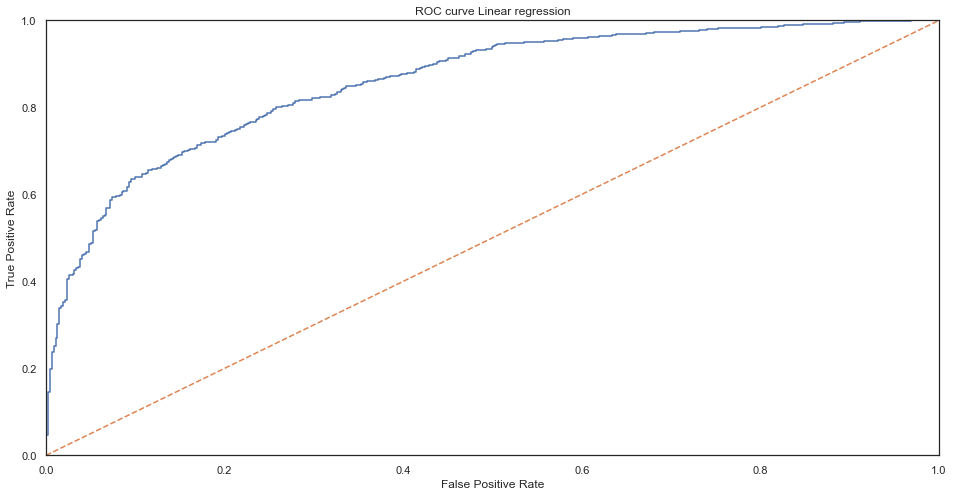

LogisticRegression()
Linear regression auc_roc score: 0.8585
Linear regression accuracy: 81.29%


In [100]:
evaluate_model("Linear regression", model_sanity_check, X_test, y_test)

### Deep Neural Network model

As I didn't find any native to keras K-FOLD cross-validation function, I used the code for manually implement it

In [101]:
# Model configuration
batch_size = 50
loss_function = 'binary_crossentropy'
no_classes = 100
no_epochs = 10
optimizer = Adam()
verbosity = 0
num_folds = 20
scores_dnn = []

acc_per_fold = []
loss_per_fold = []

inputs = X_train_upsample
targets = y_train_upsample

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

best_auc_roc_score = 0
best_model_temp = keras.models.Sequential()
for train, test in kfold.split(inputs, targets):

    # Define the model architecture
    model_dnn = keras.models.Sequential()
    model_dnn.add(Dense(10, activation='relu'))
    model_dnn.add(Dropout(0.2))
    model_dnn.add(Dense(10, activation='relu'))
    model_dnn.add(Dense(10, activation='relu'))
    model_dnn.add(Dropout(0.2))
    model_dnn.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=0.03) 

    model_dnn.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')],
    ) 

    # Generate a print
    # print('------------------------------------------------------------------------')
    # print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model_dnn.fit(inputs[train], targets[train],
        batch_size=batch_size,
        epochs=no_epochs,
        verbose=verbosity,
        validation_data=(inputs[test], targets[test]))

    # Generate generalization metrics
    scores = model_dnn.evaluate(inputs[train], targets[train], verbose=0)
    scores_train = roc_auc_score(targets[:].astype('int'), model_dnn.predict(inputs[:]))
    print('Score for fold {}: {} of {:.4f}; {} of {:.2%}; AUC_ROC of {:.4f}'.format(
        fold_no, model_dnn.metrics_names[0],
        scores[0], model_dnn.metrics_names[1],
        scores[1], scores[2]))
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    # scores_train = model_dnn.evaluate(inputs[:], targets[:].astype('int'), verbose=0)
    
    current_auc_roc_score = scores[2]
    if current_auc_roc_score > best_auc_roc_score:
        best_auc_roc_score = current_auc_roc_score
        best_model_temp = model_dnn
    
model_dnn = best_model_temp

Score for fold 1: loss of 0.4889; accuracy of 76.33%; AUC_ROC of 0.8437
Score for fold 2: loss of 0.5150; accuracy of 75.26%; AUC_ROC of 0.8373
Score for fold 3: loss of 0.4980; accuracy of 76.83%; AUC_ROC of 0.8464
Score for fold 4: loss of 0.4923; accuracy of 75.46%; AUC_ROC of 0.8424
Score for fold 5: loss of 0.5151; accuracy of 75.00%; AUC_ROC of 0.8426
Score for fold 6: loss of 0.4940; accuracy of 76.02%; AUC_ROC of 0.8398
Score for fold 7: loss of 0.5065; accuracy of 75.48%; AUC_ROC of 0.8370
Score for fold 8: loss of 0.4938; accuracy of 75.59%; AUC_ROC of 0.8407
Score for fold 9: loss of 0.4832; accuracy of 76.94%; AUC_ROC of 0.8475
Score for fold 10: loss of 0.4954; accuracy of 74.65%; AUC_ROC of 0.8429
Score for fold 11: loss of 0.4965; accuracy of 76.02%; AUC_ROC of 0.8416
Score for fold 12: loss of 0.4984; accuracy of 75.77%; AUC_ROC of 0.8430
Score for fold 13: loss of 0.4913; accuracy of 76.17%; AUC_ROC of 0.8431
Score for fold 14: loss of 0.4957; accuracy of 75.89%; AUC_R

Instructions for updating:
Please use `model.predict()` instead.


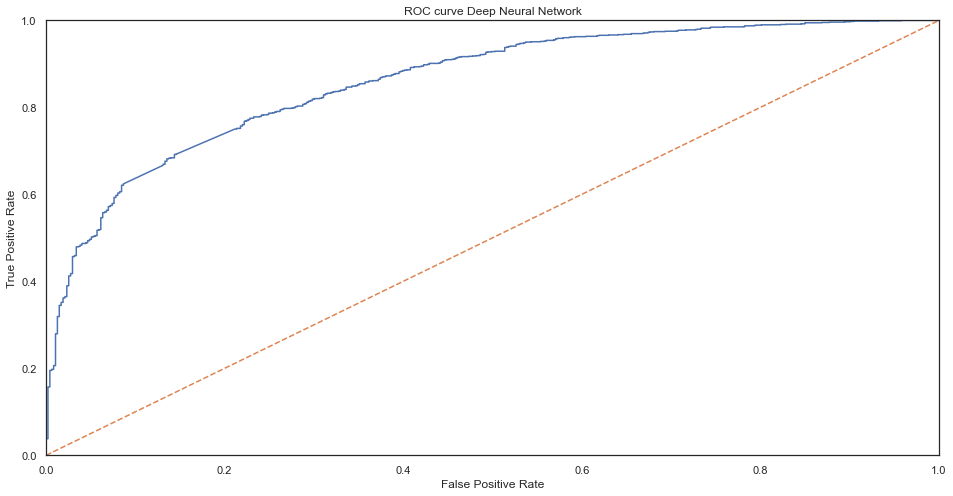

Deep Neural Network auc_roc score: 0.8598
Deep Neural Network accuracy: 77.47%


In [102]:
evaluate_model("Deep Neural Network", model_dnn, X_test, y_test)

### Deep Neural Network model - with polinomial features

In order for our neural network to be more precise lets add polinomial features to the training set

In [103]:
poly = PolynomialFeatures(3)

In [104]:
column_to_scale

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'tenure'],
      dtype='object')

Now lets select those features who turned out the most important ones according to our EDA

In [105]:
column_to_scale[1], column_to_scale[3], column_to_scale[4], column_to_scale[-1]

('PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'tenure')

In [106]:
X_train_poly = X_train_upsample.copy()
X_test_poly = X_test.copy()

In [107]:
X_train_poly = np.concatenate([np.delete(X_train_poly, (1, 3,4,-1), 1), poly.fit_transform(X_train_poly[:, (1, 3,4,-1)])], axis=1)
X_test_poly = np.concatenate([np.delete(X_test_poly, (1, 3,4,-1), 1), poly.transform(X_test_poly[:, (1, 3,4,-1)])], axis=1)

In [108]:
# Model configuration
batch_size = 50
loss_function = 'binary_crossentropy'
no_classes = 100
no_epochs = 4
optimizer = Adam()
verbosity = 0
num_folds = 20
scores_dnn = []

acc_per_fold = []
loss_per_fold = []

inputs = X_train_poly
targets = y_train_upsample

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

best_auc_roc_score = 0
best_model_temp = keras.models.Sequential()


for train, test in kfold.split(inputs, targets):

    # Define the model architecture
    model_dnn = keras.models.Sequential()
    model_dnn.add(Dense(10, activation='relu'))
    model_dnn.add(Dropout(0.2))
    model_dnn.add(Dense(10, activation='relu'))
    model_dnn.add(Dense(10, activation='relu'))
    model_dnn.add(Dropout(0.2))
    model_dnn.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=0.03) 

    model_dnn.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')],
    ) 

    # Fit data to model
    history = model_dnn.fit(inputs[train], targets[train],
        batch_size=batch_size,
        epochs=no_epochs,
        verbose=verbosity,
        validation_data=(inputs[test], targets[test]))

    # Generate generalization metrics
    scores = model_dnn.evaluate(inputs[train], targets[train], verbose=0)
    print('Score for fold {}: {} of {:.4f}; {} of {:.2%}; AUC_ROC of {:.4f}'.format(
        fold_no, model_dnn.metrics_names[0],
        scores[0], model_dnn.metrics_names[1],
        scores[1], scores[2]))
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    scores_train = model_dnn.evaluate(inputs[:], targets[:].astype('int'), verbose=0)
    
    current_auc_roc_score = scores[2]
    if current_auc_roc_score > best_auc_roc_score:
        best_auc_roc_score = current_auc_roc_score
        best_model_temp = model_dnn
    
model_dnn_polinomial = best_model_temp

Score for fold 1: loss of 0.5037; accuracy of 74.40%; AUC_ROC of 0.8375
Score for fold 2: loss of 0.5080; accuracy of 74.66%; AUC_ROC of 0.8406
Score for fold 3: loss of 0.5039; accuracy of 76.30%; AUC_ROC of 0.8415
Score for fold 4: loss of 0.5017; accuracy of 75.14%; AUC_ROC of 0.8376
Score for fold 5: loss of 0.5145; accuracy of 75.34%; AUC_ROC of 0.8389
Score for fold 6: loss of 0.5060; accuracy of 75.38%; AUC_ROC of 0.8370
Score for fold 7: loss of 0.5257; accuracy of 74.22%; AUC_ROC of 0.8275
Score for fold 8: loss of 0.5019; accuracy of 75.47%; AUC_ROC of 0.8389
Score for fold 9: loss of 0.5162; accuracy of 72.04%; AUC_ROC of 0.8400
Score for fold 10: loss of 0.5155; accuracy of 76.23%; AUC_ROC of 0.8404
Score for fold 11: loss of 0.5024; accuracy of 76.28%; AUC_ROC of 0.8350
Score for fold 12: loss of 0.4981; accuracy of 75.87%; AUC_ROC of 0.8405
Score for fold 13: loss of 0.5130; accuracy of 73.96%; AUC_ROC of 0.8368
Score for fold 14: loss of 0.5045; accuracy of 75.38%; AUC_R

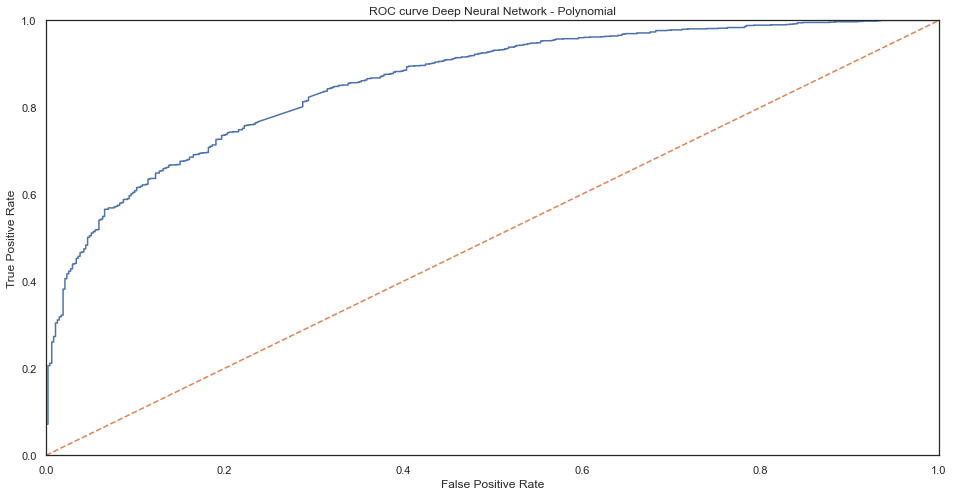

Deep Neural Network - Polynomial auc_roc score: 0.8577
Deep Neural Network - Polynomial accuracy: 72.98%


In [109]:
evaluate_model("Deep Neural Network - Polynomial", model_dnn_polinomial, X_test_poly, y_test)

### CatBoost

In [110]:
catboost_randomsearch_parameters = {
    'iterations' : range(100, 1000, 100),
    'learning_rate' : np.arange(0.001, 0.5, 0.01),
    'l2_leaf_reg' : [1e-3, 1e-2, 1, 3.5],
    'depth' : range(1, 9, 2),
    'random_state' : [26342]
    # 'depth' : [3]
    }

In [111]:
seed(4521)
model_catboost = RandomizedSearchCV(CatBoostClassifier(random_state=110,
                        verbose=False,
                        ),
                         catboost_randomsearch_parameters,
                         scoring='roc_auc',
                         cv=5,
                         n_iter=20)

In [112]:
%%time
seed(4521)
model_catboost.fit(X_train_upsample, y_train_upsample.astype('int'))

Wall time: 1min 7s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002D30FC12CD0>,
                   n_iter=20,
                   param_distributions={'depth': range(1, 9, 2),
                                        'iterations': range(100, 1000, 100),
                                        'l2_leaf_reg': [0.001, 0.01, 1, 3.5],
                                        'learning_rate': array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491]),
                                        'random_state': [26342]},
                   scoring='roc_auc')

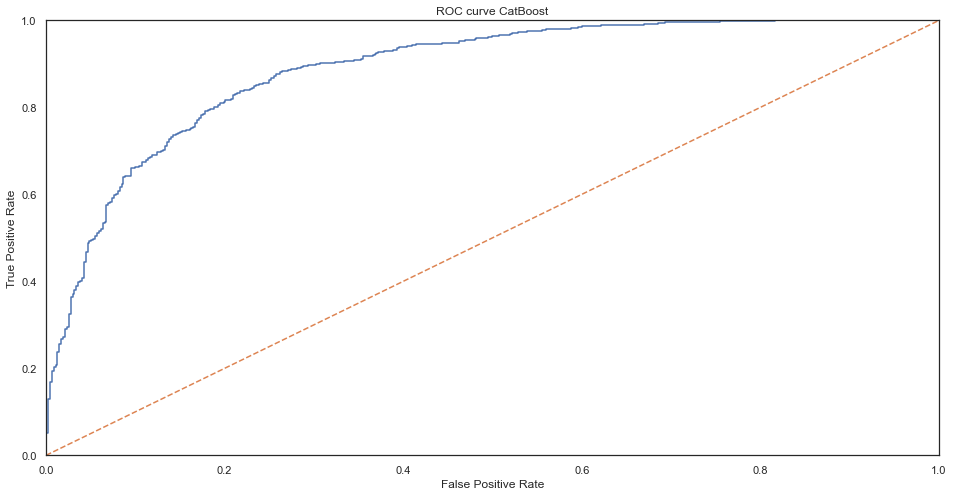

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002D30FC12CD0>,
                   n_iter=20,
                   param_distributions={'depth': range(1, 9, 2),
                                        'iterations': range(100, 1000, 100),
                                        'l2_leaf_reg': [0.001, 0.01, 1, 3.5],
                                        'learning_rate': array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491]),
                                        'random_state': [26342]},
                   scoring='roc_auc')
CatBoost auc_roc score: 0.8872
CatBoost accuracy: 84.24%


In [113]:
evaluate_model("CatBoost", model_catboost, X_test, y_test)

### RandomForest

In [114]:
model_random_forest = RandomForestClassifier(random_state=12345, n_estimators=320)
model_random_forest_initial = RandomForestClassifier(random_state=12345, class_weight="balanced")
parameters_random_forest = {
    'n_estimators' : range(85, 145, 25),
    'max_depth' : range(5, 45, 10),
    'max_features' : ['auto', 'sqrt', 'log2'],
    }

In [115]:
%%time
model_random_forest = GridSearchCV(model_random_forest, 
    param_grid=parameters_random_forest,
    cv=4,
    scoring='roc_auc',
    verbose=1,
    refit=True,
    return_train_score=True
    )
model_random_forest.fit(pd.DataFrame(X_train), y_train.astype('int'))

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Wall time: 47.2 s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=320,
                                              random_state=12345),
             param_grid={'max_depth': range(5, 45, 10),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(85, 145, 25)},
             return_train_score=True, scoring='roc_auc', verbose=1)

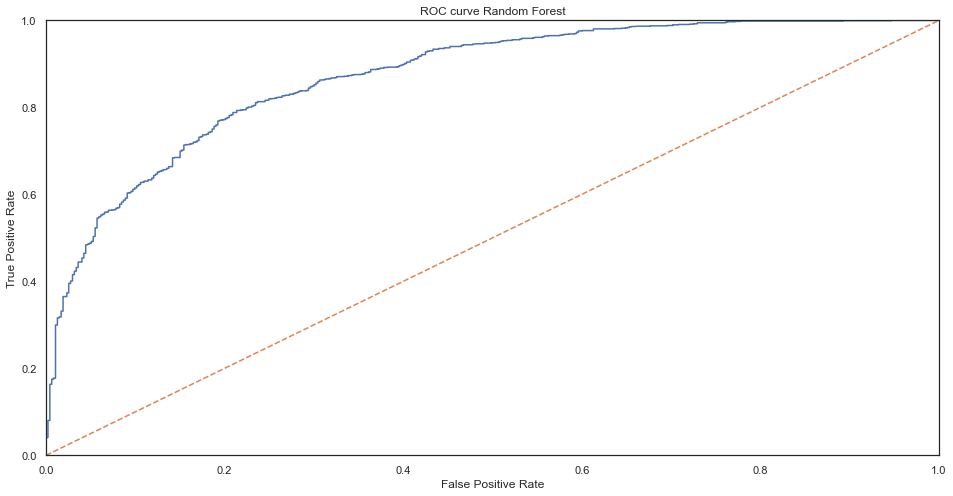

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=320,
                                              random_state=12345),
             param_grid={'max_depth': range(5, 45, 10),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(85, 145, 25)},
             return_train_score=True, scoring='roc_auc', verbose=1)
Random Forest auc_roc score: 0.8709
Random Forest accuracy: 82.65%


In [116]:
evaluate_model("Random Forest", model_random_forest, X_test, y_test)

### XGBoost

In [117]:
xgboost_randomsearch_parameters = {
    'subsample' : np.linspace(0.8, 1, 2),
    'learning_rate' : (0.01, 0.1, 0.01),
    'n_estimators' : [100, 250, 500, 750],
    'max_depth' : range(4, 12, 2)
    }

In [118]:
model_xgb = RandomizedSearchCV(XGBClassifier(random_state=32561),
    xgboost_randomsearch_parameters,
    scoring='roc_auc',
    cv=5,
    n_iter=20,
    verbose=0,)

In [119]:
%%time
model_xgb.fit(X_train, y_train.astype('int'))

Wall time: 43.4 s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=32561,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=20,
                   param_distributions={'learning_rate': (0.01, 0.1, 0.01),
                                        'max_depth': range(4, 12, 2),
                                        'n_estimators': [100, 250, 500, 750],
                                        'subsample': array([0.8, 1. ])},
                   scoring='roc_auc')

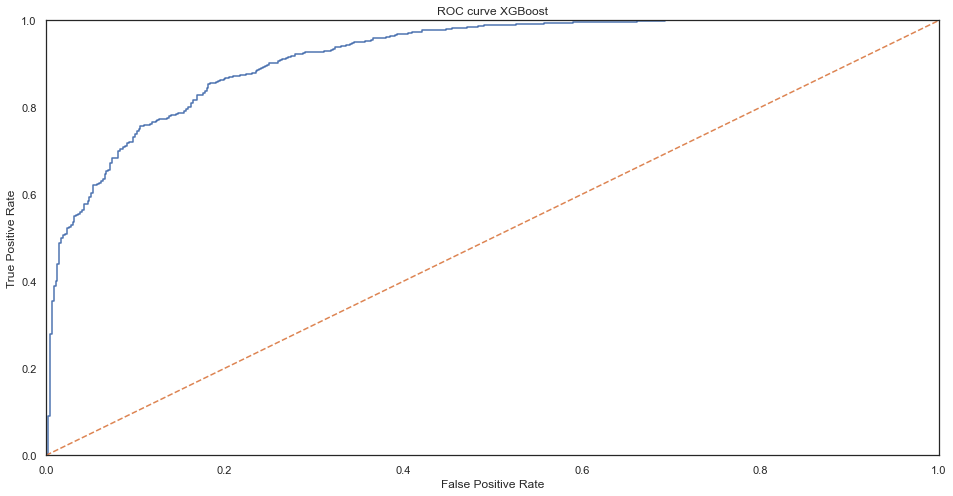

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [120]:
evaluate_model("XGBoost", model_xgb, X_test, y_test)

### LightGBM

In [121]:
model_lightGBM = lgb.LGBMClassifier()

parameters_light_gbm = {
    'task' : ['predict'],
    # 'boosting': ['gbdt' ],
    'num_iterations': range(10, 100,10),
    'num_leaves':range(10,100, 10),
    'max_depth' :range(180,210,10),
    'class_weight':['balanced'],
    'learning_rate':[0.1,0.2,0.3,0.4],
    'verbose':[-1]
 }

In [122]:
%%time

model_lightGBM = GridSearchCV(model_lightGBM, param_grid = parameters_light_gbm, verbose=0,cv=5,scoring = 'roc_auc')
model_lightGBM.fit(X_train_upsample, y_train_upsample)

Wall time: 3min 39s


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_depth': range(180, 210, 10),
                         'num_iterations': range(10, 100, 10),
                         'num_leaves': range(10, 100, 10), 'task': ['predict'],
                         'verbose': [-1]},
             scoring='roc_auc')

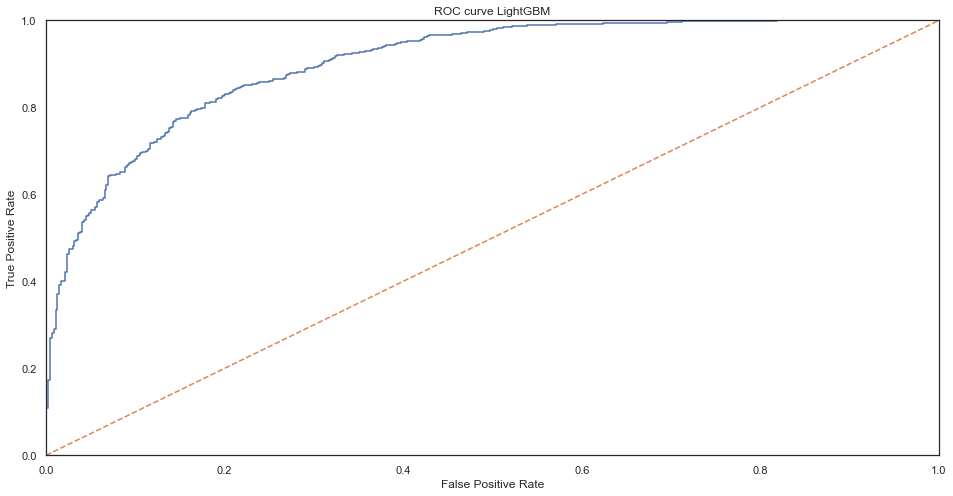

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_depth': range(180, 210, 10),
                         'num_iterations': range(10, 100, 10),
                         'num_leaves': range(10, 100, 10), 'task': ['predict'],
                         'verbose': [-1]},
             scoring='roc_auc')
LightGBM auc_roc score: 0.9020
LightGBM accuracy: 85.44%


In [123]:
evaluate_model("LightGBM", model_lightGBM, X_test, y_test)

## Model results

In [124]:
display(df_model_result)

,Model,model_roc_auc_score
0,XGBoost,0.918365
1,LightGBM,0.902016
2,CatBoost,0.887219
3,Random Forest,0.870946
4,Deep Neural Network,0.859819
5,Linear regression,0.858517
6,Deep Neural Network - Polynomial,0.85766


## Initial Clarifying questions
* Which features to extract
* Is it better to keep new customers in the dataset (e.g. registered 0 days before the dataset was updated)
* Should I do the train-test or train-validation-test split. If I choose to train with cross validation then there is no need for validation set
* There are 7K records in the contract dataset. However only 4.5K of the customers are also present in the all the datasets (31.5% missing values). Would it be better to dismiss the records with missing data, or will it be better to to try to fill the missing values
* Would it be better to choose all the features for the model or dismiss some irrelevant ones
* The dataset is unbalanced. What would be the optimal approach to tackle the class imbalance?
* What encoding to use for categorical features?

## Conclusion

We performed EDA and saw which features affect the churn rate and how.  
We also saw which features are more important.  
Than we preprocessed the data:  
* We filled the missing values
* Removed excess features to avoid target leakag
* Encoded the data with OrdinalEncoder
* Upsampled to tackle the clasbalance
* Scaled the data

Finally we trained 7 different models including LinearRegression as the baseline model for the sanity check.

### Best perfoming model 
**XGBoost**  
AUC_ROC: 0.918